# Comparing Proportional Selection and SUS Selection
In this notebook, I will compare the results of using proportional selection and SUS selection. 

In [21]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from distributed import Client, LocalCluster


from leap_ec.algorithm import generational_ea
from leap_ec.individual import Individual
from leap_ec.representation import Representation
import leap_ec.ops as ops
from leap_ec import probe
from leap_ec.global_vars import context
from leap_ec.distrib import synchronous


from leap_ec.real_rep.problems import LangermannProblem
from leap_ec.real_rep.ops import mutate_gaussian
from leap_ec.real_rep.initializers import create_real_vector

## Define Parameters

In [22]:
MAX_GEN = 1000  # number of generations per iteration
POP_SIZE = 10     # population size
NUM_ITER = 100    # total number of iterations per selection operator
BOUNDS = [[0, 10]]*2  # bounds for LangermannProblem
CONFIDENCE = 0.99 # confidence interval for plot

## Run Proportional and Track Stats
First code cell tests a synchronous evaluations scheme (currently very slow for unknown reasons).

In [23]:
# with Client(LocalCluster(n_workers=os.cpu_count(), threads_per_worker=1, processes=True)) as client:
#     with open('./proportional_stats.csv', 'w') as prop_file:
#         prop_stats_probe = probe.FitnessStatsCSVProbe(stream=prop_file, context=context)
#         for i in tqdm(range(NUM_ITER)):
#             prop_stats_probe.bsf_ind = None
#             ea = generational_ea(max_generations=MAX_GEN, pop_size=POP_SIZE,
#                                  problem=LangermannProblem(maximize=True),
#                                  init_evaluate=synchronous.eval_population(client=client),
#                                  representation=Representation(
#                                      initialize=create_real_vector(bounds=BOUNDS)
#                                  ),
#                                  pipeline=[
#                                      ops.proportional_selection(offset='pop-min'),
#                                      ops.clone,
#                                      ops.uniform_crossover(p_swap=0.2),
#                                      mutate_gaussian(std=0.5, expected_num_mutations='isotropic'),
#                                      synchronous.eval_pool(size=POP_SIZE,client=client),
#                                      prop_stats_probe
#                                  ])
#             list(ea);

In [25]:
with open('./proportional_stats.csv', 'w') as prop_file:
    prop_stats_probe = probe.FitnessStatsCSVProbe(stream=prop_file, context=context)
    for i in tqdm(range(NUM_ITER)):
        prop_stats_probe.bsf_ind = None
        ea = generational_ea(max_generations=MAX_GEN, pop_size=POP_SIZE,
                             problem=LangermannProblem(maximize=True),
                             representation=Representation(
                                 initialize=create_real_vector(bounds=BOUNDS)
                             ),
                             pipeline=[
                                 ops.proportional_selection(offset='pop-min'),
                                 ops.clone,
                                 ops.uniform_crossover(p_swap=0.2),
                                 mutate_gaussian(std=0.5, expected_num_mutations='isotropic'),
                                 ops.evaluate,
                                 ops.pool(size=POP_SIZE),
                                 prop_stats_probe
                             ])
        list(ea);

100%|██████████| 100/100 [03:32<00:00,  2.13s/it]


## Run SUS and Track Stats

In [26]:
sus_file = open('./SUS_stats.csv', 'w')
sus_stats_probe = probe.FitnessStatsCSVProbe(stream=sus_file, context=context)
for i in tqdm(range(NUM_ITER)):
    sus_stats_probe.bsf_ind = None
    ea = generational_ea(max_generations=MAX_GEN, pop_size=POP_SIZE,
                         problem=LangermannProblem(maximize=True),
                         representation=Representation(
                             initialize=create_real_vector(bounds=BOUNDS)
                         ),
                         pipeline=[
                             ops.sus_selection(n=POP_SIZE, offset='pop-min'),
                             ops.clone,
                             ops.uniform_crossover(p_swap=0.2),
                             mutate_gaussian(std=0.5, expected_num_mutations='isotropic'),
                             ops.evaluate,
                             ops.pool(size=POP_SIZE),
                             sus_stats_probe
                         ])
    list(ea);
sus_file.close()

100%|██████████| 100/100 [03:24<00:00,  2.05s/it]


## Data Manipulation

In [27]:
import pandas as pd
from scipy import stats
import numpy as np

# read in data and calculate averages
prop_df = pd.read_csv('proportional_stats.csv')
sus_df = pd.read_csv('SUS_stats.csv')

prop_df_step = prop_df.groupby('step').mean()
sus_df_step = sus_df.groupby('step').mean()

sus_df_step.to_csv('SUS_avg_stats.csv')
prop_df_step.to_csv('prop_avg_stats.csv')

prop_bsf = prop_df_step[' bsf'].values
sus_bsf = sus_df_step[' bsf'].values

## Compute Confidence Intervals

In [28]:
# create lists to store +/- (up/down) confidence intervals for each generation
prop_conf_up = []
prop_conf_down = []
sus_conf_up = []
sus_conf_down = []
for i in range(MAX_GEN):
    prop_step_data = prop_df[prop_df['step'] == i][' bsf'].values
    sus_step_data = sus_df[sus_df['step'] == i][' bsf'].values
    prop_int_up, prop_int_down = stats.t.interval(CONFIDENCE, len(prop_step_data)-1, loc=prop_bsf[i], scale=stats.sem(prop_step_data)) 
    sus_int_up, sus_int_down = stats.t.interval(CONFIDENCE, len(sus_step_data)-1, loc=sus_bsf[i], scale=stats.sem(sus_step_data))
    prop_conf_up.append(prop_int_up)
    prop_conf_down.append(prop_int_down)
    sus_conf_up.append(sus_int_up)
    sus_conf_down.append(sus_int_down)
    
print(prop_conf_up[0:10])
print(prop_conf_down[0:10])
print(sus_conf_up[0:10])
print(sus_conf_down[0:10])

[1.286528014869905, 1.6257750787869172, 1.845300864219922, 1.9768914954068326, 2.0487917118671386, 2.1486201637287055, 2.2217436404288264, 2.3064308002895184, 2.3350434885004097, 2.382099553105276]
[1.8156476559847667, 2.16438676288721, 2.385111761999357, 2.537733304851122, 2.6195904253057702, 2.7053052017112913, 2.7715817901959374, 2.850649243510191, 2.870978648030478, 2.916480608276998]
[1.3779717650188563, 1.727145041956802, 1.9057794201512301, 2.0750250542359527, 2.1784066278929486, 2.259614838794253, 2.3298953444840724, 2.4264435371385336, 2.4875477683108027, 2.579914889191088]
[1.9184027714371168, 2.234775425659409, 2.4209557754876103, 2.5927763871655642, 2.697381336589254, 2.7679251328230365, 2.8478486070384377, 2.947738093000705, 3.010643977183461, 3.095927617000808]


## Plot Result

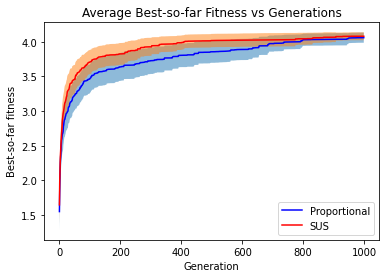

In [29]:
steps = list(range(MAX_GEN))
plt.plot(steps, prop_bsf, color='blue', label='Proportional')
plt.fill_between(steps, prop_conf_up, prop_conf_down, alpha=0.5)
plt.plot(steps, sus_bsf, color='red', label='SUS')
plt.fill_between(steps, sus_conf_up, sus_conf_down, alpha=0.5)
plt.legend()
plt.ylabel('Best-so-far fitness')
plt.xlabel('Generation')
plt.title('Average Best-so-far Fitness vs Generations')
plt.savefig(f'prop_vs_sus_bsf_conf{CONFIDENCE}_langermann.png')

plt.show()
